In [29]:
import pykat
from pykat import finesse
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

In [16]:
base = finesse.kat()
base.verbose=False
base.parse("""

# ======== Constants ========================
const f1 16.881M
const f2 45.0159M
const mf1 -16.881M
const mf2 -45.0159M
const a 0.686

# ======== Input optics =====================
l i1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 $f1 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 $f2 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 nREFL

## ======= PRC each mirror loss 45ppm =======
m1 PRM 0.1 45e-6 0 nREFL npr1
s sLpr1 14.7615 npr1 npr2
bs1 PR2 500e-6 45e-6 0 $a npr3 npr2 nPOP nPOP2
s sLpr2 11.0661 npr3 npr4
bs1 PR3 50e-6 45e-6 0 $a dump dump npr4 npr5
s sLpr3 15.7638 npr5 npr6

# Michelson
bs bs1 0.5 0.5 0 45 npr6 n2 n3 nAS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1

# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.999995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.999995 5e-06 90 ny3 nTMSY

## ======= detectors ================

ad CR_POP 0 nPOP
ad SB1p_POP $f1 nPOP
ad SB1m_POP $mf1 nPOP
ad SB2p_POP $f2 nPOP
ad SB2m_POP $mf2 nPOP

ad CR_TMSX 0_TMSX nTMSX
ad SB1p_TMSX $f1 nTMSX
ad SB1m_TMSX $mf1 nTMSX
ad SB2p_TMSX $f2 nTMSX
ad SB2m_TMSX $mf2 nTMSX


pd1 REFLI1 $f1 0 nREFL
pd1 REFLQ1 $f1 90 nREFL

pd1 REFLI2 $f2 0 nREFL
pd1 REFLQ2 $f2 90 nREFL

pd1 POPI1 $f1 119 nPOP
pd1 POPQ1 $f1 209 nPOP

pd1 POPI2 $f2 74 nPOP
pd1 POPQ2 $f2 164 nPOP

pd1 ASQ1 $f1 0 nAS
pd1 ASQ2 $f2 178 nAS

""")

## Field Check (POP, TMSX)

<function matplotlib.pyplot.show(*args, **kw)>

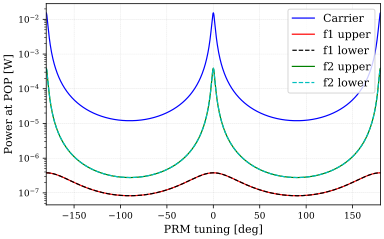

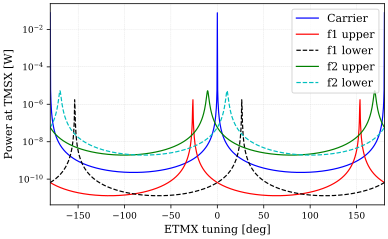

In [17]:
kat0 = base.deepcopy()
kat0.parse("""
xaxis* PRM phi lin -180 180 1000
""")

out = kat0.run()
plt.figure(1)
plt.semilogy(out.x, out["CR_POP"]**2,label="Carrier")
plt.semilogy(out.x, out["SB1p_POP"]**2,label="f1 upper")
plt.semilogy(out.x, out["SB1m_POP"]**2,label="f1 lower",LineStyle='--')
plt.semilogy(out.x, out["SB2p_POP"]**2,label="f2 upper")
plt.semilogy(out.x, out["SB2m_POP"]**2,label="f2 lower",LineStyle='--')
plt.xlabel("PRM tuning [deg]")
plt.ylabel("Power at POP [W]")
plt.legend(loc=1)
plt.show

kat1 = base.deepcopy()
kat1.parse("""
xaxis* ETMX phi lin -180 180 1000
""")

out1 = kat1.run()

plt.figure(2)
plt.semilogy(out.x, out1["CR_TMSX"]**2,label="Carrier")
plt.semilogy(out.x, out1["SB1p_TMSX"]**2,label="f1 upper")
plt.semilogy(out.x, out1["SB1m_TMSX"]**2,label="f1 lower",LineStyle='--')
plt.semilogy(out.x, out1["SB2p_TMSX"]**2,label="f2 upper")
plt.semilogy(out.x, out1["SB2m_TMSX"]**2,label="f2 lower",LineStyle='--')
plt.xlabel("ETMX tuning [deg]")
plt.ylabel("Power at TMSX [W]")
plt.legend(loc=1)
plt.show



## Error Signals

Text(0, 0.5, 'POPQ2')

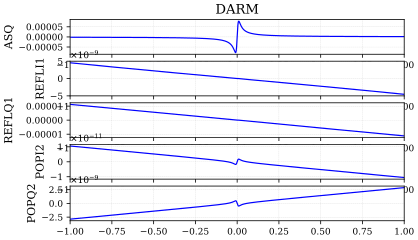

In [18]:
DARM_sweep = base.deepcopy()
DARM_sweep.parse("""
var tuning 0
xaxis tuning phi lin -1 1 10000
put ETMX phi $x1
put* ETMY phi $mx1
yaxis abs
""")

DARM = DARM_sweep.run()

plt.subplot(5,1,1)
plt.plot(DARM.x, DARM["ASQ2"],label="ASQ2")
plt.ylabel('ASQ')
plt.title('DARM')

plt.subplot(5,1,2)
plt.plot(DARM.x, DARM["REFLI1"])
plt.ylabel('REFLI1')

plt.subplot(5,1,3)
plt.plot(DARM.x, DARM["REFLQ1"])
plt.ylabel('REFLQ1')


plt.subplot(5,1,4)
plt.plot(DARM.x, DARM["POPI1"])
plt.ylabel('POPI2')

plt.subplot(5,1,5)
plt.plot(DARM.x, DARM["POPQ1"])
plt.ylabel('POPQ2')


<function matplotlib.pyplot.show(*args, **kw)>

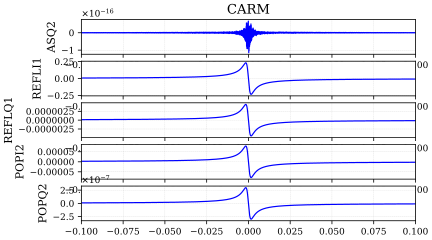

In [19]:
CARM_sweep = base.deepcopy()
CARM_sweep.parse("""
var tuning 0
xaxis tuning phi lin -.1 .1 10000
put ETMX phi $x1
put* ETMY phi $x1
yaxis abs
""")

CARM = CARM_sweep.run()

plt.subplot(5,1,1)
plt.plot(CARM.x, CARM["ASQ2"],label="ASQ2")
plt.ylabel('ASQ2')
plt.title('CARM')

plt.subplot(5,1,2)
plt.plot(CARM.x, CARM["REFLI1"])
plt.ylabel('REFLI1')

plt.subplot(5,1,3)
plt.plot(CARM.x, CARM["REFLQ1"])
plt.ylabel('REFLQ1')


plt.subplot(5,1,4)
plt.plot(CARM.x, CARM["POPI1"])
plt.ylabel('POPI2')

plt.subplot(5,1,5)
plt.plot(CARM.x, CARM["POPQ1"])
plt.ylabel('POPQ2')

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

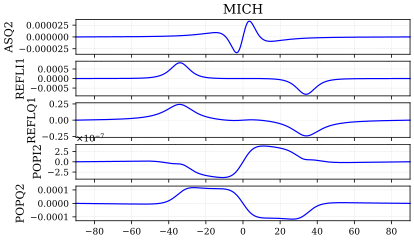

In [20]:
MICH_sweep = base.deepcopy()
MICH_sweep.parse("""
var tuning 0
xaxis tuning phi lin -90 90 10000
put ITMX phi $x1
put* ITMY phi $mx1
put ETMX phi $x1
put* ETMY phi $mx1
yaxis abs
""")

MICH = MICH_sweep.run()

plt.subplot(5,1,1)
plt.plot(MICH.x, MICH["ASQ2"],label="ASQ2")
plt.ylabel('ASQ2')
plt.title('MICH')

plt.subplot(5,1,2)
plt.plot(MICH.x, MICH["REFLI1"])
plt.ylabel('REFLI1')

plt.subplot(5,1,3)
plt.plot(MICH.x, MICH["REFLQ1"])
plt.ylabel('REFLQ1')


plt.subplot(5,1,4)
plt.plot(MICH.x, MICH["POPI1"])
plt.ylabel('POPI2')

plt.subplot(5,1,5)
plt.plot(MICH.x, MICH["POPQ1"])
plt.ylabel('POPQ2')

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

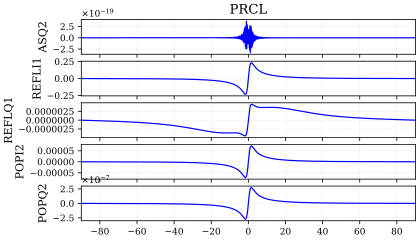

In [21]:
PRCL_sweep = base.deepcopy()
PRCL_sweep.parse("""
var tuning 0
xaxis tuning phi lin -90 90 10000
put PRM phi $x1
yaxis lin abs
""")

PRCL = PRCL_sweep.run()

plt.subplot(5,1,1)
plt.plot(PRCL.x, PRCL["ASQ2"],label="ASQ2")
plt.ylabel('ASQ2')
plt.title('PRCL')

plt.subplot(5,1,2)
plt.plot(PRCL.x, PRCL["REFLI1"])
plt.ylabel('REFLI1')

plt.subplot(5,1,3)
plt.plot(PRCL.x, PRCL["REFLQ1"])
plt.ylabel('REFLQ1')


plt.subplot(5,1,4)
plt.plot(PRCL.x, PRCL["POPI1"])
plt.ylabel('POPI2')

plt.subplot(5,1,5)
plt.plot(PRCL.x, PRCL["POPQ1"])
plt.ylabel('POPQ2')

plt.show

## Signal Slope
### Deriving manially

In [27]:
DoF = ['DARM','MICH','CARM','PRCL']
probe = ['ASQ1','REFLI1','REFLQ1','POPI1','POPQ1']

for i in range(5):
    for D in DoF:
        print(D,probe[i])
        d_x = eval(D).x[5001]-eval(D).x[4999]
        d_y = eval(D)[probe[i]][5001] - eval(D)[probe[i]][4999]
        print(d_y/d_x)
        


DARM ASQ1
21.519798664539945
MICH ASQ1
0.021572204724422867
CARM ASQ1
-1.4668429165477723e-09
PRCL ASQ1
4.976443694900151e-15
DARM REFLI1
9.971125298261821e-09
MICH REFLI1
7.550266866863546e-07
CARM REFLI1
-289.94741127499253
PRCL REFLI1
0.29134482550101337
DARM REFLQ1
9.930106008305668e-06
MICH REFLQ1
0.001951239686637394
CARM REFLQ1
-0.0055606032535639865
PRCL REFLQ1
5.259227286328054e-06
DARM POPI1
3.8124910590021394e-10
MICH POPI1
7.457757775388736e-08
CARM POPI1
-0.09797423489864066
PRCL POPI1
8.980562260427139e-05
DARM POPQ1
-1.0286535946544981e-07
MICH POPQ1
-2.0203201077480963e-05
CARM POPQ1
-0.0003717525992378193
PRCL POPQ1
3.4161971429193264e-07


|   |  DARM  | MICH | CARM | PRCL|
| ---- | ---- |   ---- |  ---- |  ---- |
|  ASQ1 |  22 |  0.022  |  -1.5e-9  |  4.9e-15  |
| REFLI1  |  1.0e-8  |  7.6e-7  |  -300  |  0.29  |
| REFLQ1  |  9.9e-6  |  0.0020  |  -0.0056  |  5.3e-6  |
| POPI1  |  3.8e-10  |  7.5e-8  |  -0.098  |  9.0e-5  |
| POPQ1  | -1.0e-7  |  -2.0e-5  |  -0.00037  |  3.4e-7  |

In [28]:
DoF = ['DARM','MICH','CARM','PRCL']
probe = ['ASQ2','REFLI2','REFLQ2','POPI2','POPQ2']

for i in range(5):
    for D in DoF:
        print(D,probe[i])
        d_x = eval(D).x[5001]-eval(D).x[4999]
        d_y = eval(D)[probe[i]][5001] - eval(D)[probe[i]][4999]
        print(d_y/d_x)

DARM ASQ2
0.016247376721770287
MICH ASQ2
1.6286760445401737e-05
CARM ASQ2
-1.1074618217035246e-12
PRCL ASQ2
-2.0240754620481637e-19
DARM REFLI2
-9.096725922444797e-09
MICH REFLI2
-8.13772689612159e-08
CARM REFLI2
318.15306203866623
PRCL REFLI2
-0.0010968664681965737
DARM REFLQ2
-4.50329218360018e-07
MICH REFLQ2
-1.5138414266365215e-05
CARM REFLQ2
-1.7320323617041185
PRCL REFLQ2
2.7715897925492886e-05
DARM POPI2
2.3099202345145616e-10
MICH POPI2
9.969691104895351e-09
CARM POPI2
3.133205435962763
PRCL POPI2
0.0001433070536536468
DARM POPQ2
-4.66032727362494e-09
MICH POPQ2
-1.5642959321649896e-07
CARM POPQ2
0.20791946982416812
PRCL POPQ2
8.861979671404986e-07


In [ ]:
|   |  DARM  | MICH | CARM | PRCL|
| ---- | ---- |   ---- |  ---- |  ---- |
|  ASQ2 |  0.016 |  1.6e-5  |  -1.1e-12  | -2.0e-19 |
| REFLI2  |  -9.1e-9  |  -8.1e-8  |  320  |  -0.0011  |
| REFLQ2  |  -4.5e-7 |  -1.5e-5  |  -1.7  |  2.8e-5 |
| POPI2 |  2.3e-10  |  1.0e-8  |  3.1  | 0.00014 |
| POPQ2  | -4.7e-9 | -1.6e-7  |  0.21  |  8.9e-7 |

<function matplotlib.pyplot.show(*args, **kw)>

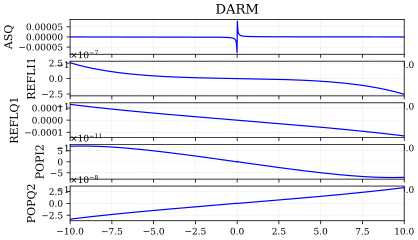

In [13]:
DARM_sweep = base.deepcopy()
DARM_sweep.parse("""
var tuning 0
xaxis tuning phi lin -10 10 10000
put ETMX phi $x1
put* ETMY phi $mx1
yaxis abs
""")

DARM = DARM_sweep.run()

plt.subplot(5,1,1)
plt.plot(DARM.x, DARM["ASQ2"],label="ASQ2")
plt.ylabel('ASQ')
plt.title('DARM')

plt.subplot(5,1,2)
plt.plot(DARM.x, DARM["REFLI1"])
plt.ylabel('REFLI1')

plt.subplot(5,1,3)
plt.plot(DARM.x, DARM["REFLQ1"])
plt.ylabel('REFLQ1')


plt.subplot(5,1,4)
plt.plot(DARM.x, DARM["POPI1"])
plt.ylabel('POPI2')

plt.subplot(5,1,5)
plt.plot(DARM.x, DARM["POPQ1"])
plt.ylabel('POPQ2')

plt.show

Text(0, 0.5, 'POPQ2')

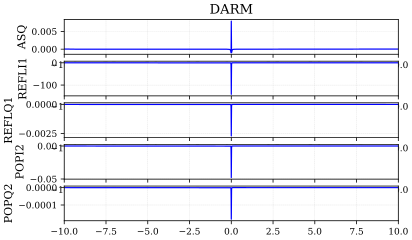

In [14]:
DARM_sweep = base.deepcopy()
DARM_sweep.parse("""
var tuning 0
xaxis tuning phi lin -10 10 10000
put ETMX phi $x1
put* ETMY phi $mx1
diff tuning phi
yaxis abs
""")

DARM = DARM_sweep.run()

plt.subplot(5,1,1)
plt.plot(DARM.x, DARM["ASQ2"],label="ASQ2")
plt.ylabel('ASQ')
plt.title('DARM')

plt.subplot(5,1,2)
plt.plot(DARM.x, DARM["REFLI1"])
plt.ylabel('REFLI1')

plt.subplot(5,1,3)
plt.plot(DARM.x, DARM["REFLQ1"])
plt.ylabel('REFLQ1')


plt.subplot(5,1,4)
plt.plot(DARM.x, DARM["POPI1"])
plt.ylabel('POPI2')

plt.subplot(5,1,5)
plt.plot(DARM.x, DARM["POPQ1"])
plt.ylabel('POPQ2')
